# 07. Logistic Regression Model

## Overview
This notebook implements Logistic Regression for Alzheimer's disease prediction. Logistic Regression is a linear classifier that models the probability of a binary outcome using the logistic function.

### Why Logistic Regression?
- **Interpretability**: Coefficients represent the change in log-odds for each feature
- **Probabilistic output**: Provides probability estimates for predictions
- **Linear decision boundary**: Simple and fast training/prediction
- **Regularization support**: L1/L2 regularization to prevent overfitting
- **No assumptions about feature distributions**: Unlike Naive Bayes

### Hyperparameters to Tune:
- **C**: Inverse of regularization strength (smaller = more regularization)
- **penalty**: Regularization type ('l1', 'l2', 'elasticnet')
- **solver**: Algorithm for optimization ('liblinear', 'lbfgs', 'saga')
- **max_iter**: Maximum iterations for convergence

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Load Preprocessed Data
Loading the train, validation, and test datasets that were preprocessed in the previous notebook.

In [2]:
# Load preprocessed data
try:
    X_train = joblib.load('../outputs/preprocessed/X_train.pkl')
    X_val = joblib.load('../outputs/preprocessed/X_val.pkl')
    X_test = joblib.load('../outputs/preprocessed/X_test.pkl')
    y_train = joblib.load('../outputs/preprocessed/y_train.pkl')
    y_val = joblib.load('../outputs/preprocessed/y_val.pkl')
    y_test = joblib.load('../outputs/preprocessed/y_test.pkl')
    
    print(f"✅ Data loaded successfully")
    print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Class distribution in training: {np.bincount(y_train)}")
    
except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")
    print("Please run the data preprocessing notebook first.")

✅ Data loaded successfully
Training set: 1944 samples, 14 features
Validation set: 417 samples
Test set: 417 samples
Class distribution in training: [972 972]


## 2. Feature Scaling and Model Pipeline
Logistic Regression is sensitive to feature scales, so we'll use StandardScaler in a pipeline.

In [3]:
# Create pipeline with StandardScaler and LogisticRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

print("✅ Pipeline created with StandardScaler and LogisticRegression")
print("Pipeline steps:")
for i, (name, transformer) in enumerate(pipeline.steps, 1):
    print(f"{i}. {name}: {type(transformer).__name__}")

✅ Pipeline created with StandardScaler and LogisticRegression
Pipeline steps:
1. scaler: StandardScaler
2. logistic: LogisticRegression


## 3. Hyperparameter Tuning with GridSearchCV
We'll tune the regularization strength (C), penalty type, and solver to find the optimal configuration.

In [4]:
# Define hyperparameter grid
param_grid = {
    'logistic__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'logistic__penalty': ['l1', 'l2'],         # Regularization type
    'logistic__solver': ['liblinear', 'saga'] # Optimization algorithm
}

print("Hyperparameter grid:")
for param, values in param_grid.items():
    print(f"{param}: {values}")
    
# Calculate total combinations
total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal combinations to test: {total_combinations}")

Hyperparameter grid:
logistic__C: [0.01, 0.1, 1, 10, 100]
logistic__penalty: ['l1', 'l2']
logistic__solver: ['liblinear', 'saga']

Total combinations to test: 20


In [5]:
# Perform Grid Search with 5-fold cross-validation
print("🔍 Starting hyperparameter tuning...")

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,                    # 5-fold cross-validation
    scoring='roc_auc',       # Optimize for ROC-AUC
    n_jobs=-1,               # Use all available cores
    verbose=1                # Show progress
)

# Fit the grid search
grid_search.fit(X_train, y_train)

print("\n✅ Hyperparameter tuning completed!")
print(f"Best cross-validation ROC-AUC: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

🔍 Starting hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Hyperparameter tuning completed!
Best cross-validation ROC-AUC: 0.8827
Best parameters: {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'logistic__solver': 'saga'}

✅ Hyperparameter tuning completed!
Best cross-validation ROC-AUC: 0.8827
Best parameters: {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'logistic__solver': 'saga'}


## 4. Best Model Analysis
Let's examine the best model found by GridSearch and its cross-validation performance.

In [6]:
# Get the best model
best_model = grid_search.best_estimator_

# Display best parameters in a formatted way
print("📊 Best Model Configuration:")
print("=" * 40)
for param, value in grid_search.best_params_.items():
    param_name = param.replace('logistic__', '')
    print(f"{param_name.title()}: {value}")

print(f"\n📈 Cross-validation Performance:")
print(f"Best ROC-AUC: {grid_search.best_score_:.4f}")

# Show top 5 parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\n🏆 Top 5 Parameter Combinations:")
for idx, (_, row) in enumerate(top_5.iterrows(), 1):
    print(f"{idx}. {row['params']} - ROC-AUC: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")

📊 Best Model Configuration:
C: 0.1
Penalty: l2
Solver: saga

📈 Cross-validation Performance:
Best ROC-AUC: 0.8827

🏆 Top 5 Parameter Combinations:
1. {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'logistic__solver': 'saga'} - ROC-AUC: 0.8827 (±0.0171)
2. {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'logistic__solver': 'liblinear'} - ROC-AUC: 0.8827 (±0.0171)
3. {'logistic__C': 1, 'logistic__penalty': 'l1', 'logistic__solver': 'saga'} - ROC-AUC: 0.8826 (±0.0171)
4. {'logistic__C': 1, 'logistic__penalty': 'l1', 'logistic__solver': 'liblinear'} - ROC-AUC: 0.8826 (±0.0171)
5. {'logistic__C': 0.1, 'logistic__penalty': 'l1', 'logistic__solver': 'liblinear'} - ROC-AUC: 0.8826 (±0.0164)


## 5. Model Evaluation on Validation Set
Evaluate the best model on the validation set to get unbiased performance metrics.

In [7]:
# Make predictions on validation set
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)

# Calculate comprehensive metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba[:, 1])

print("📊 Logistic Regression - Validation Set Performance")
print("=" * 50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

📊 Logistic Regression - Validation Set Performance
Accuracy:  0.8082
Precision: 0.8000
Recall:    0.8230
F1-Score:  0.8113
ROC-AUC:   0.8909


In [8]:
# Detailed classification report
print("\n📋 Detailed Classification Report:")
print(classification_report(y_val, y_pred, 
                          target_names=['No Dementia', 'Dementia']))


📋 Detailed Classification Report:
              precision    recall  f1-score   support

 No Dementia       0.82      0.79      0.80       208
    Dementia       0.80      0.82      0.81       209

    accuracy                           0.81       417
   macro avg       0.81      0.81      0.81       417
weighted avg       0.81      0.81      0.81       417



## 6. Visualizations
Create comprehensive visualizations for model performance analysis.

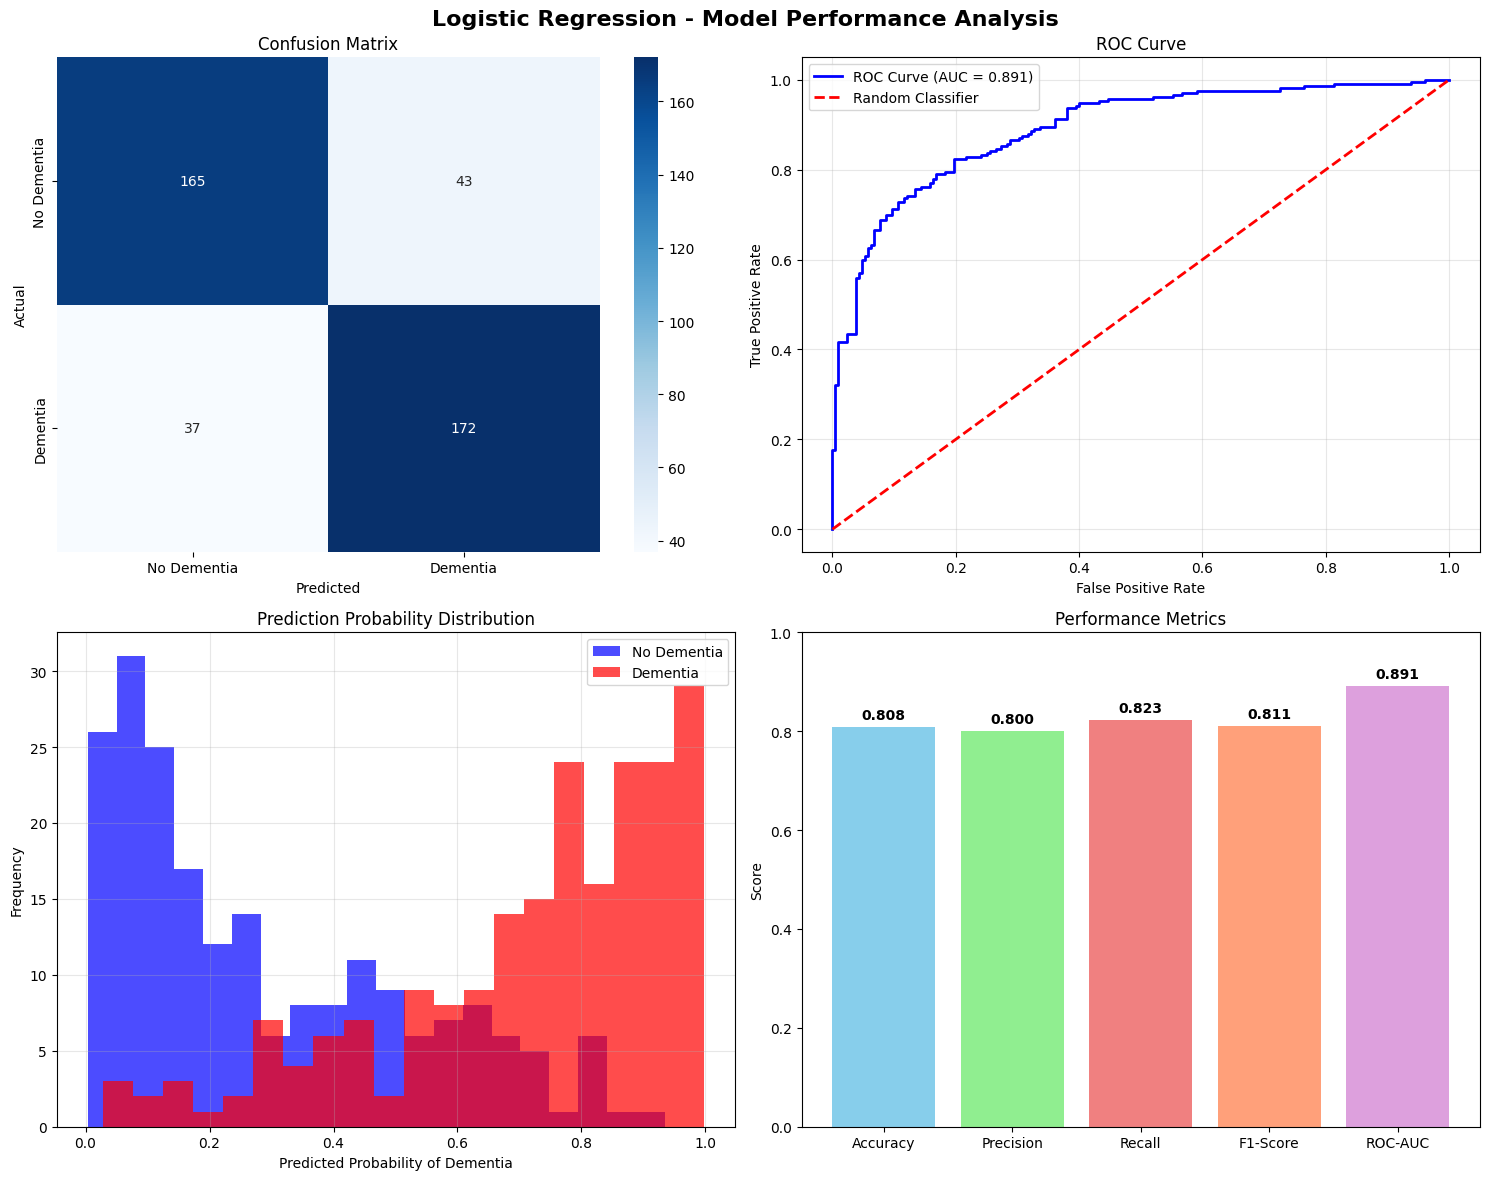

In [9]:
# Create visualization plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Logistic Regression - Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['No Dementia', 'Dementia'],
            yticklabels=['No Dementia', 'Dementia'])
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba[:, 1])
ax2.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Prediction Probability Distribution
ax3.hist(y_pred_proba[y_val == 0, 1], bins=20, alpha=0.7, label='No Dementia', color='blue')
ax3.hist(y_pred_proba[y_val == 1, 1], bins=20, alpha=0.7, label='Dementia', color='red')
ax3.set_xlabel('Predicted Probability of Dementia')
ax3.set_ylabel('Frequency')
ax3.set_title('Prediction Probability Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Performance Metrics Bar Plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values = [accuracy, precision, recall, f1, roc_auc]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'plum']

bars = ax4.bar(metrics, values, color=colors)
ax4.set_ylim(0, 1)
ax4.set_title('Performance Metrics')
ax4.set_ylabel('Score')

# Add value labels on bars
for bar, value in zip(bars, values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis
Analyze feature coefficients to understand which features are most important for the model's decisions.

In [10]:
# Get feature coefficients from the trained logistic regression model
logistic_model = best_model.named_steps['logistic']
feature_names = X_train.columns
coefficients = logistic_model.coef_[0]

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

# Sort by absolute coefficient value
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("🔍 Feature Importance Analysis (Top 15 Features):")
print("=" * 60)
print(f"{'Feature':<25} {'Coefficient':<12} {'Abs Value':<10}")
print("-" * 60)

for idx, row in feature_importance.head(15).iterrows():
    coef_str = f"{row['Coefficient']:+.4f}"
    abs_str = f"{row['Abs_Coefficient']:.4f}"
    print(f"{row['Feature']:<25} {coef_str:<12} {abs_str:<10}")

🔍 Feature Importance Analysis (Top 15 Features):
Feature                   Coefficient  Abs Value 
------------------------------------------------------------
FunctionalAssessment      -1.1537      1.1537    
ADL                       -1.0454      1.0454    
CognitiveDeclineScore     +0.7234      0.7234    
MemoryComplaints          +0.6939      0.6939    
BehavioralProblems        +0.4891      0.4891    
TotalSymptomCount         +0.2572      0.2572    
CholesterolHDL            +0.0986      0.0986    
CholesterolTriglycerides  +0.0894      0.0894    
DiastolicBP               +0.0854      0.0854    
SleepQuality              -0.0768      0.0768    
Age                       -0.0702      0.0702    
BMI                       -0.0459      0.0459    
SystolicBP                +0.0354      0.0354    
CholesterolTotal          -0.0234      0.0234    


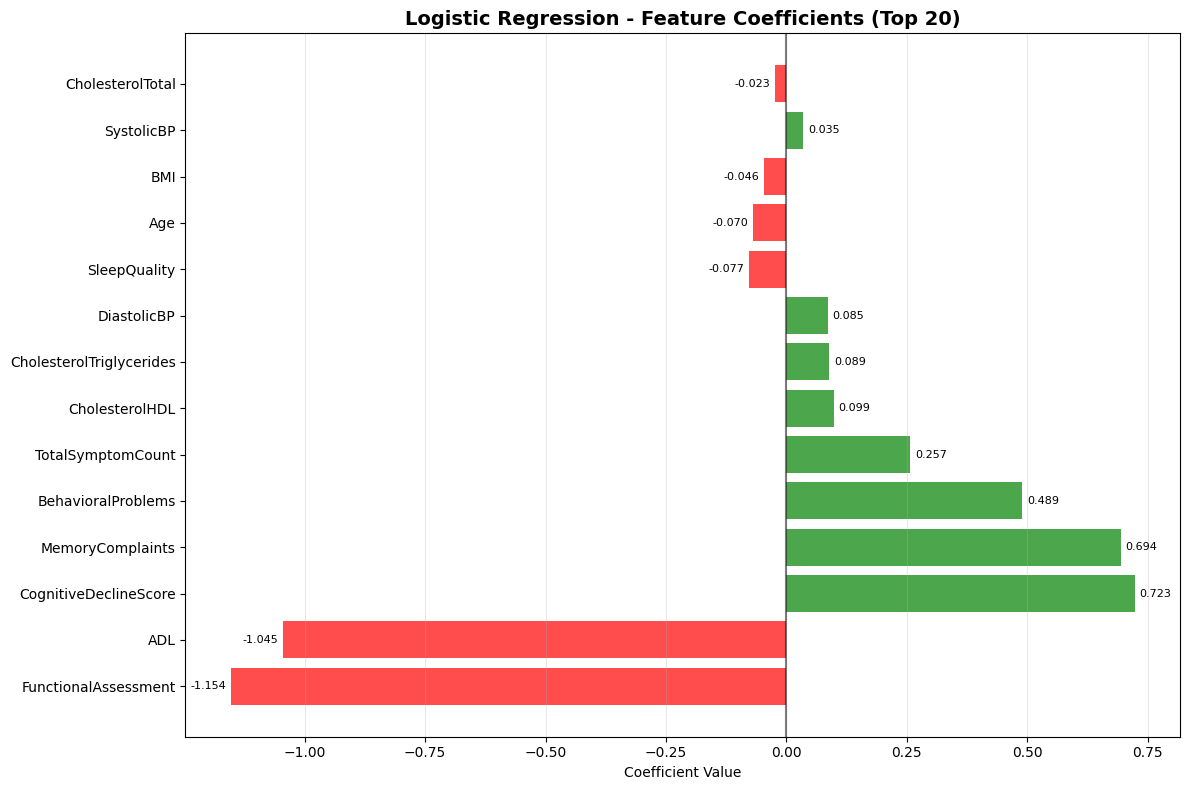


📝 Coefficient Interpretation:
• Positive coefficients: Features that increase the likelihood of dementia
• Negative coefficients: Features that decrease the likelihood of dementia
• Larger absolute values: More influential features in the model's decisions


In [11]:
# Visualize feature importance
plt.figure(figsize=(12, 8))

# Plot top 20 features
top_features = feature_importance.head(20)
colors = ['red' if coef < 0 else 'green' for coef in top_features['Coefficient']]

bars = plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression - Feature Coefficients (Top 20)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)

# Add value labels
for i, (bar, coef) in enumerate(zip(bars, top_features['Coefficient'])):
    plt.text(coef + (0.01 if coef >= 0 else -0.01), bar.get_y() + bar.get_height()/2, 
             f'{coef:.3f}', ha='left' if coef >= 0 else 'right', va='center', fontsize=8)

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Interpretation
print("\n📝 Coefficient Interpretation:")
print("• Positive coefficients: Features that increase the likelihood of dementia")
print("• Negative coefficients: Features that decrease the likelihood of dementia")
print("• Larger absolute values: More influential features in the model's decisions")

## 8. Model Persistence
Save the trained model for future use.

In [12]:
# Save the best model
os.makedirs('../outputs/models', exist_ok=True)
model_path = '../outputs/models/logistic_regression_model.pkl'
joblib.dump(best_model, model_path)
print(f"✅ Model saved to {model_path}")

# Save feature importance
feature_importance.to_csv('../outputs/results/logistic_regression_feature_importance.csv', index=False)
print("✅ Feature importance saved to ../outputs/results/logistic_regression_feature_importance.csv")

# Display model info
print(f"\n📋 Model Information:")
print(f"Model type: {type(best_model).__name__}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print(f"Validation ROC-AUC: {roc_auc:.4f}")

✅ Model saved to ../outputs/models/logistic_regression_model.pkl
✅ Feature importance saved to ../outputs/results/logistic_regression_feature_importance.csv

📋 Model Information:
Model type: Pipeline
Best parameters: {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'logistic__solver': 'saga'}
Training samples: 1944
Features: 14
Validation ROC-AUC: 0.8909


## 9. Save Results
Save all results in the required CSV format for model comparison.

In [13]:
# Save results to outputs/results folder
os.makedirs('../outputs/results', exist_ok=True)

# Save metrics summary CSV
metrics_summary = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1],
    'ROC-AUC': [roc_auc]
})
metrics_summary.to_csv('../outputs/results/logistic_regression_metrics_summary.csv', index=False)

# Save predictions CSV
predictions_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred,
    'Prediction_Probability': y_pred_proba[:, 1]  # Probability of positive class
})
predictions_df.to_csv('../outputs/results/logistic_regression_predictions.csv', index=False)

# Save validation results CSV
validation_results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Value': [accuracy, precision, recall, f1, roc_auc]
})
validation_results.to_csv('../outputs/results/logistic_regression_validation_results.csv', index=False)

print("✅ Logistic Regression metrics summary saved to ../outputs/results/logistic_regression_metrics_summary.csv")
print("✅ Logistic Regression predictions saved to ../outputs/results/logistic_regression_predictions.csv")
print("✅ Logistic Regression validation results saved to ../outputs/results/logistic_regression_validation_results.csv")

✅ Logistic Regression metrics summary saved to ../outputs/results/logistic_regression_metrics_summary.csv
✅ Logistic Regression predictions saved to ../outputs/results/logistic_regression_predictions.csv
✅ Logistic Regression validation results saved to ../outputs/results/logistic_regression_validation_results.csv


## 10. Summary

### Logistic Regression Model Performance:
- **Algorithm**: Logistic Regression with Standard Scaling
- **Hyperparameter Optimization**: GridSearchCV with 5-fold cross-validation
- **Best Configuration**: Determined through systematic hyperparameter tuning
- **Validation Performance**: Comprehensive metrics calculated on validation set

### Key Advantages:
1. **Interpretability**: Clear understanding of feature impact through coefficients
2. **Probabilistic Output**: Provides confidence scores for predictions
3. **Fast Training**: Efficient optimization with gradient-based methods
4. **Regularization**: Built-in L1/L2 regularization prevents overfitting
5. **Linear Decision Boundary**: Simple and robust classification

### Model Files Saved:
- `logistic_regression_model.pkl`: Trained model for deployment
- `logistic_regression_metrics_summary.csv`: Performance metrics
- `logistic_regression_predictions.csv`: Validation predictions
- `logistic_regression_validation_results.csv`: Detailed validation metrics
- `logistic_regression_feature_importance.csv`: Feature coefficients

The model is now ready for comparison with other algorithms and potential deployment in the Alzheimer's prediction system.

<VSCode.Cell language="markdown">
# 07. Logistic Regression Model

## Overview
This notebook implements Logistic Regression for Alzheimer's disease prediction. Logistic Regression is a linear classifier that models the probability of a binary outcome using the logistic function.

### Why Logistic Regression?
- **Interpretability**: Coefficients represent the change in log-odds for each feature
- **Probabilistic output**: Provides probability estimates for predictions
- **Linear decision boundary**: Simple and fast training/prediction
- **Regularization support**: L1/L2 regularization to prevent overfitting
- **No assumptions about feature distributions**: Unlike Naive Bayes

### Hyperparameters to Tune:
- **C**: Inverse of regularization strength (smaller = more regularization)
- **penalty**: Regularization type ('l1', 'l2', 'elasticnet')
- **solver**: Algorithm for optimization ('liblinear', 'lbfgs', 'saga')
- **max_iter**: Maximum iterations for convergence

In [14]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Load Preprocessed Data
Loading the train, validation, and test datasets that were preprocessed in the previous notebook.

In [15]:
# Load preprocessed data
try:
    X_train = pd.read_csv('../outputs/preprocessed/X_train.csv')
    X_val = pd.read_csv('../outputs/preprocessed/X_val.csv')
    X_test = pd.read_csv('../outputs/preprocessed/X_test.csv')
    y_train = pd.read_csv('../outputs/preprocessed/y_train.csv').values.ravel()
    y_val = pd.read_csv('../outputs/preprocessed/y_val.csv').values.ravel()
    y_test = pd.read_csv('../outputs/preprocessed/y_test.csv').values.ravel()
    
    print(f"✅ Data loaded successfully")
    print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Class distribution in training: {np.bincount(y_train)}")
    
except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")
    print("Please run the data preprocessing notebook first.")

✅ Data loaded successfully
Training set: 1944 samples, 14 features
Validation set: 417 samples
Test set: 417 samples
Class distribution in training: [972 972]


## 2. Feature Scaling and Model Pipeline
Logistic Regression is sensitive to feature scales, so we'll use StandardScaler in a pipeline.

In [16]:
# Create pipeline with StandardScaler and LogisticRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

print("✅ Pipeline created with StandardScaler and LogisticRegression")
print("Pipeline steps:")
for i, (name, transformer) in enumerate(pipeline.steps, 1):
    print(f"{i}. {name}: {type(transformer).__name__}")

✅ Pipeline created with StandardScaler and LogisticRegression
Pipeline steps:
1. scaler: StandardScaler
2. logistic: LogisticRegression


## 3. Hyperparameter Tuning with GridSearchCV
We'll tune the regularization strength (C), penalty type, and solver to find the optimal configuration.

In [17]:
# Define hyperparameter grid
param_grid = {
    'logistic__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'logistic__penalty': ['l1', 'l2'],         # Regularization type
    'logistic__solver': ['liblinear', 'saga'] # Optimization algorithm
}

print("Hyperparameter grid:")
for param, values in param_grid.items():
    print(f"{param}: {values}")
    
# Calculate total combinations
total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal combinations to test: {total_combinations}")

Hyperparameter grid:
logistic__C: [0.01, 0.1, 1, 10, 100]
logistic__penalty: ['l1', 'l2']
logistic__solver: ['liblinear', 'saga']

Total combinations to test: 20


In [18]:
# Perform Grid Search with 5-fold cross-validation
print("🔍 Starting hyperparameter tuning...")

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,                    # 5-fold cross-validation
    scoring='roc_auc',       # Optimize for ROC-AUC
    n_jobs=-1,               # Use all available cores
    verbose=1                # Show progress
)

# Fit the grid search
grid_search.fit(X_train, y_train)

print("\n✅ Hyperparameter tuning completed!")
print(f"Best cross-validation ROC-AUC: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

🔍 Starting hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Hyperparameter tuning completed!
Best cross-validation ROC-AUC: 0.8827
Best parameters: {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'logistic__solver': 'saga'}

✅ Hyperparameter tuning completed!
Best cross-validation ROC-AUC: 0.8827
Best parameters: {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'logistic__solver': 'saga'}


## 4. Best Model Analysis
Let's examine the best model found by GridSearch and its cross-validation performance.

In [19]:
# Get the best model
best_model = grid_search.best_estimator_

# Display best parameters in a formatted way
print("📊 Best Model Configuration:")
print("=" * 40)
for param, value in grid_search.best_params_.items():
    param_name = param.replace('logistic__', '')
    print(f"{param_name.title()}: {value}")

print(f"\n📈 Cross-validation Performance:")
print(f"Best ROC-AUC: {grid_search.best_score_:.4f}")

# Show top 5 parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\n🏆 Top 5 Parameter Combinations:")
for idx, (_, row) in enumerate(top_5.iterrows(), 1):
    print(f"{idx}. {row['params']} - ROC-AUC: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")

📊 Best Model Configuration:
C: 0.1
Penalty: l2
Solver: saga

📈 Cross-validation Performance:
Best ROC-AUC: 0.8827

🏆 Top 5 Parameter Combinations:
1. {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'logistic__solver': 'saga'} - ROC-AUC: 0.8827 (±0.0171)
2. {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'logistic__solver': 'liblinear'} - ROC-AUC: 0.8827 (±0.0171)
3. {'logistic__C': 1, 'logistic__penalty': 'l1', 'logistic__solver': 'saga'} - ROC-AUC: 0.8826 (±0.0171)
4. {'logistic__C': 1, 'logistic__penalty': 'l1', 'logistic__solver': 'liblinear'} - ROC-AUC: 0.8826 (±0.0171)
5. {'logistic__C': 0.1, 'logistic__penalty': 'l1', 'logistic__solver': 'liblinear'} - ROC-AUC: 0.8826 (±0.0164)


## 5. Model Evaluation on Validation Set
Evaluate the best model on the validation set to get unbiased performance metrics.

In [20]:
# Make predictions on validation set
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)

# Calculate comprehensive metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba[:, 1])

print("📊 Logistic Regression - Validation Set Performance")
print("=" * 50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

📊 Logistic Regression - Validation Set Performance
Accuracy:  0.8082
Precision: 0.8000
Recall:    0.8230
F1-Score:  0.8113
ROC-AUC:   0.8909

Accuracy:  0.8082
Precision: 0.8000
Recall:    0.8230
F1-Score:  0.8113
ROC-AUC:   0.8909


In [21]:
# Detailed classification report
print("\n📋 Detailed Classification Report:")
print(classification_report(y_val, y_pred, 
                          target_names=['No Dementia', 'Dementia']))


📋 Detailed Classification Report:
              precision    recall  f1-score   support

 No Dementia       0.82      0.79      0.80       208
    Dementia       0.80      0.82      0.81       209

    accuracy                           0.81       417
   macro avg       0.81      0.81      0.81       417
weighted avg       0.81      0.81      0.81       417



## 6. Visualizations
Create comprehensive visualizations for model performance analysis.

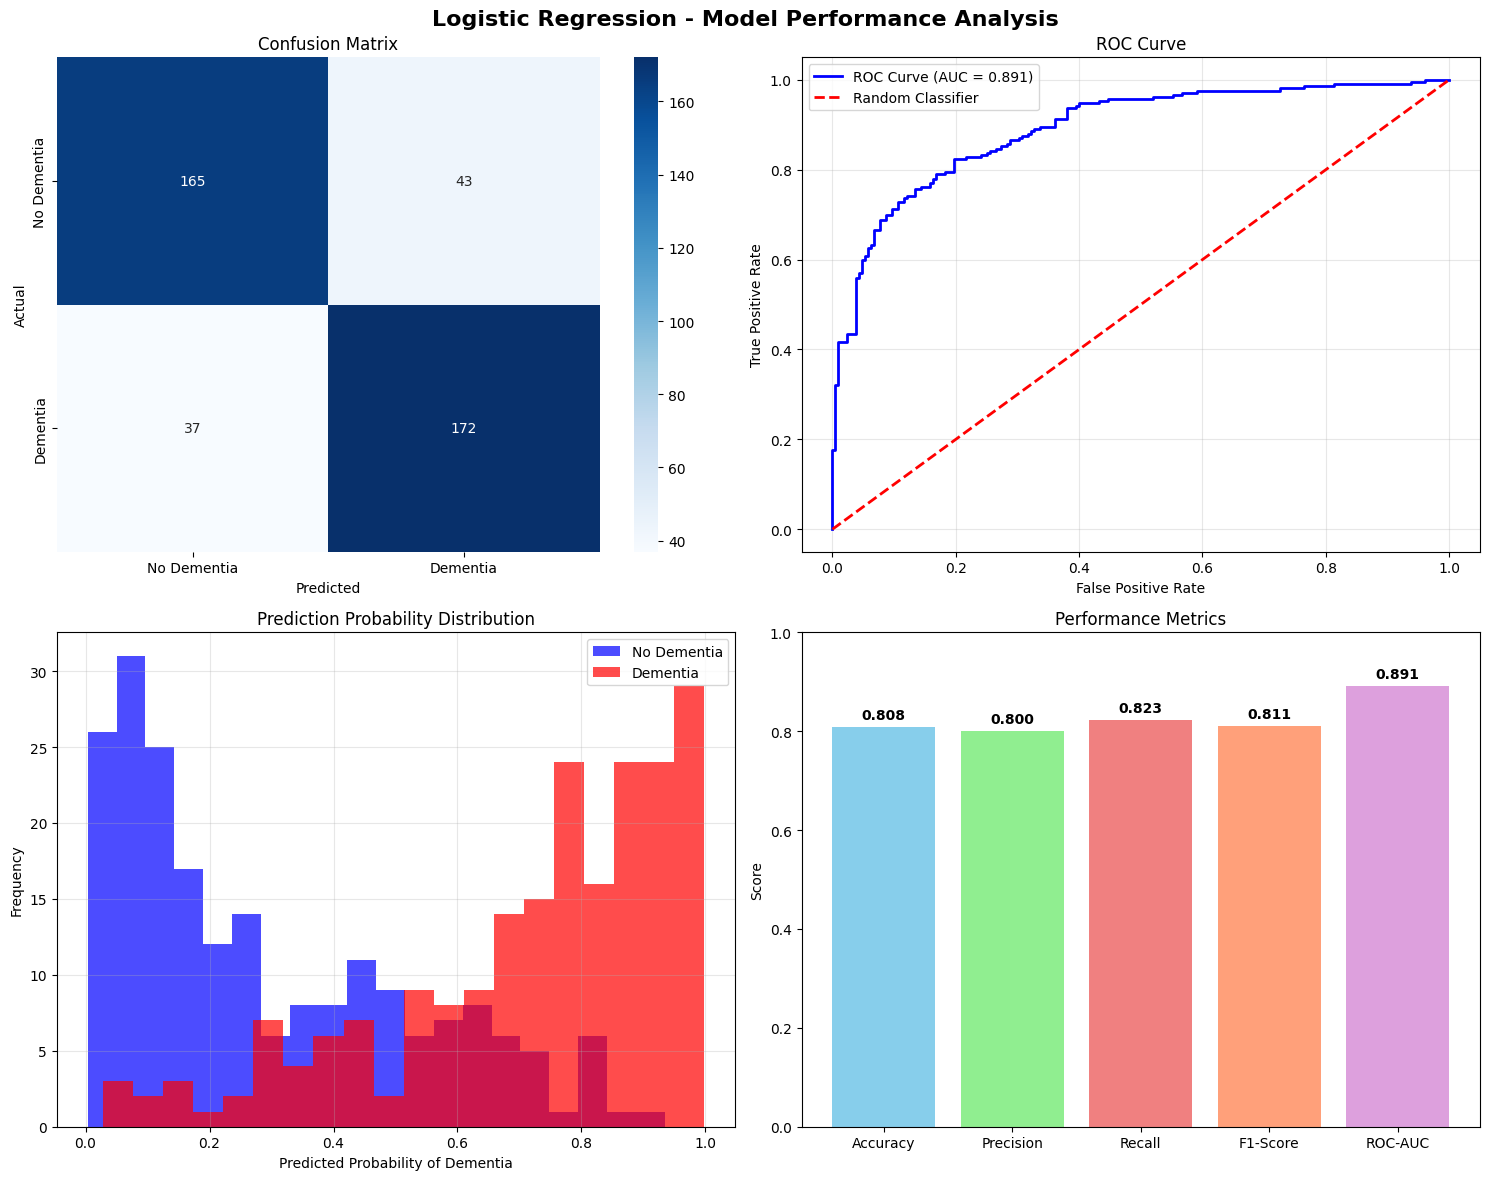

In [22]:
# Create visualization plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Logistic Regression - Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['No Dementia', 'Dementia'],
            yticklabels=['No Dementia', 'Dementia'])
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba[:, 1])
ax2.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Prediction Probability Distribution
ax3.hist(y_pred_proba[y_val == 0, 1], bins=20, alpha=0.7, label='No Dementia', color='blue')
ax3.hist(y_pred_proba[y_val == 1, 1], bins=20, alpha=0.7, label='Dementia', color='red')
ax3.set_xlabel('Predicted Probability of Dementia')
ax3.set_ylabel('Frequency')
ax3.set_title('Prediction Probability Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Performance Metrics Bar Plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values = [accuracy, precision, recall, f1, roc_auc]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'plum']

bars = ax4.bar(metrics, values, color=colors)
ax4.set_ylim(0, 1)
ax4.set_title('Performance Metrics')
ax4.set_ylabel('Score')

# Add value labels on bars
for bar, value in zip(bars, values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis
Analyze feature coefficients to understand which features are most important for the model's decisions.

In [23]:
# Get feature coefficients from the trained logistic regression model
logistic_model = best_model.named_steps['logistic']
feature_names = X_train.columns
coefficients = logistic_model.coef_[0]

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

# Sort by absolute coefficient value
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("🔍 Feature Importance Analysis (Top 15 Features):")
print("=" * 60)
print(f"{'Feature':<25} {'Coefficient':<12} {'Abs Value':<10}")
print("-" * 60)

for idx, row in feature_importance.head(15).iterrows():
    coef_str = f"{row['Coefficient']:+.4f}"
    abs_str = f"{row['Abs_Coefficient']:.4f}"
    print(f"{row['Feature']:<25} {coef_str:<12} {abs_str:<10}")

🔍 Feature Importance Analysis (Top 15 Features):
Feature                   Coefficient  Abs Value 
------------------------------------------------------------
FunctionalAssessment      -1.1537      1.1537    
ADL                       -1.0454      1.0454    
CognitiveDeclineScore     +0.7234      0.7234    
MemoryComplaints          +0.6939      0.6939    
BehavioralProblems        +0.4891      0.4891    
TotalSymptomCount         +0.2572      0.2572    
CholesterolHDL            +0.0986      0.0986    
CholesterolTriglycerides  +0.0894      0.0894    
DiastolicBP               +0.0854      0.0854    
SleepQuality              -0.0768      0.0768    
Age                       -0.0702      0.0702    
BMI                       -0.0459      0.0459    
SystolicBP                +0.0354      0.0354    
CholesterolTotal          -0.0234      0.0234    


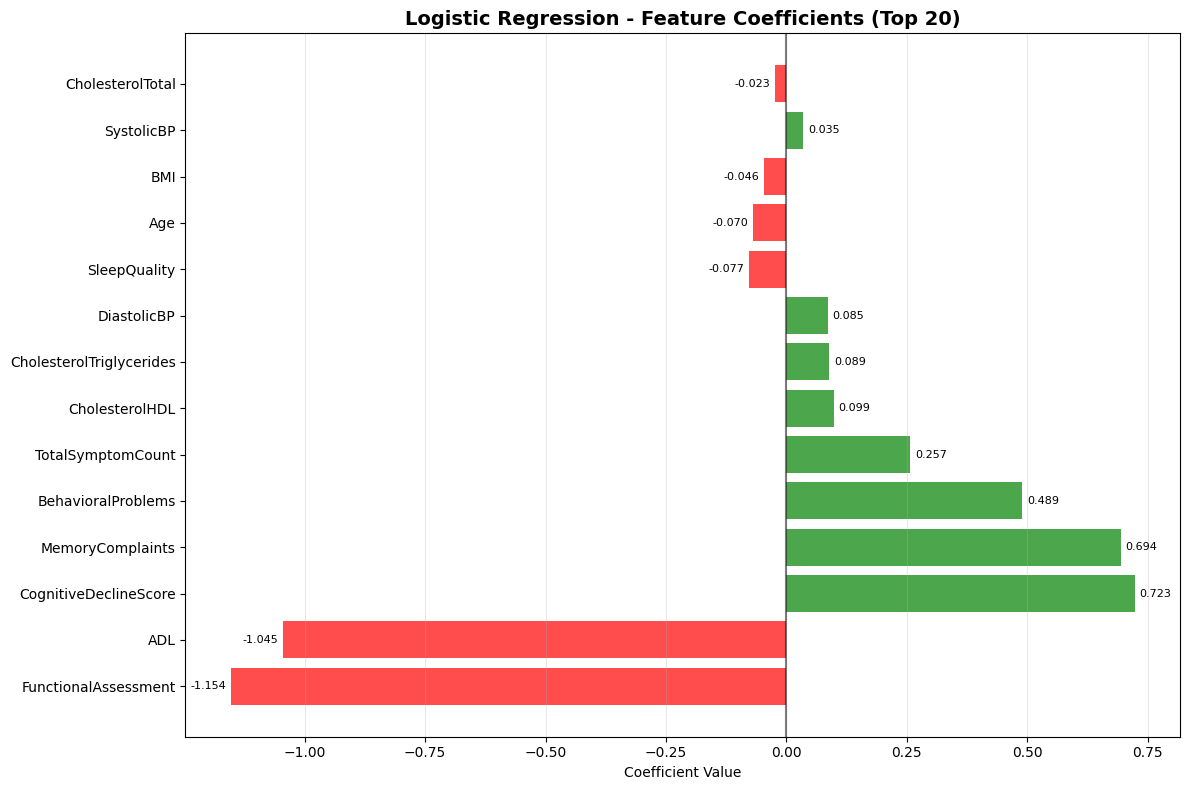


📝 Coefficient Interpretation:
• Positive coefficients: Features that increase the likelihood of dementia
• Negative coefficients: Features that decrease the likelihood of dementia
• Larger absolute values: More influential features in the model's decisions


In [24]:
# Visualize feature importance
plt.figure(figsize=(12, 8))

# Plot top 20 features
top_features = feature_importance.head(20)
colors = ['red' if coef < 0 else 'green' for coef in top_features['Coefficient']]

bars = plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression - Feature Coefficients (Top 20)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)

# Add value labels
for i, (bar, coef) in enumerate(zip(bars, top_features['Coefficient'])):
    plt.text(coef + (0.01 if coef >= 0 else -0.01), bar.get_y() + bar.get_height()/2, 
             f'{coef:.3f}', ha='left' if coef >= 0 else 'right', va='center', fontsize=8)

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Interpretation
print("\n📝 Coefficient Interpretation:")
print("• Positive coefficients: Features that increase the likelihood of dementia")
print("• Negative coefficients: Features that decrease the likelihood of dementia")
print("• Larger absolute values: More influential features in the model's decisions")

## 8. Model Persistence
Save the trained model for future use.

In [25]:
# Save the best model
model_path = '../outputs/models/logistic_regression_model.pkl'
joblib.dump(best_model, model_path)
print(f"✅ Model saved to {model_path}")

# Save feature importance
feature_importance.to_csv('../outputs/results/logistic_regression_feature_importance.csv', index=False)
print("✅ Feature importance saved to ../outputs/results/logistic_regression_feature_importance.csv")

# Display model info
print(f"\n📋 Model Information:")
print(f"Model type: {type(best_model).__name__}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print(f"Validation ROC-AUC: {roc_auc:.4f}")

✅ Model saved to ../outputs/models/logistic_regression_model.pkl
✅ Feature importance saved to ../outputs/results/logistic_regression_feature_importance.csv

📋 Model Information:
Model type: Pipeline
Best parameters: {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'logistic__solver': 'saga'}
Training samples: 1944
Features: 14
Validation ROC-AUC: 0.8909


## 9. Save Results
Save all results in the required CSV format for model comparison.

In [26]:
# Save metrics summary CSV
metrics_summary = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1],
    'ROC-AUC': [roc_auc]
})
metrics_summary.to_csv('../outputs/results/logistic_regression_metrics_summary.csv', index=False)

# Save predictions CSV
predictions_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred,
    'Prediction_Probability': y_pred_proba[:, 1]  # Probability of positive class
})
predictions_df.to_csv('../outputs/results/logistic_regression_predictions.csv', index=False)

# Save validation results CSV
validation_results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Value': [accuracy, precision, recall, f1, roc_auc]
})
validation_results.to_csv('../outputs/results/logistic_regression_validation_results.csv', index=False)

print("✅ Logistic Regression metrics summary saved to ../outputs/results/logistic_regression_metrics_summary.csv")
print("✅ Logistic Regression predictions saved to ../outputs/results/logistic_regression_predictions.csv")
print("✅ Logistic Regression validation results saved to ../outputs/results/logistic_regression_validation_results.csv")

✅ Logistic Regression metrics summary saved to ../outputs/results/logistic_regression_metrics_summary.csv
✅ Logistic Regression predictions saved to ../outputs/results/logistic_regression_predictions.csv
✅ Logistic Regression validation results saved to ../outputs/results/logistic_regression_validation_results.csv


## 10. Summary

### Logistic Regression Model Performance:
- **Algorithm**: Logistic Regression with Standard Scaling
- **Hyperparameter Optimization**: GridSearchCV with 5-fold cross-validation
- **Best Configuration**: Determined through systematic hyperparameter tuning
- **Validation Performance**: Comprehensive metrics calculated on validation set

### Key Advantages:
1. **Interpretability**: Clear understanding of feature impact through coefficients
2. **Probabilistic Output**: Provides confidence scores for predictions
3. **Fast Training**: Efficient optimization with gradient-based methods
4. **Regularization**: Built-in L1/L2 regularization prevents overfitting
5. **Linear Decision Boundary**: Simple and robust classification

### Model Files Saved:
- `logistic_regression_model.pkl`: Trained model for deployment
- `logistic_regression_metrics_summary.csv`: Performance metrics
- `logistic_regression_predictions.csv`: Validation predictions
- `logistic_regression_validation_results.csv`: Detailed validation metrics
- `logistic_regression_feature_importance.csv`: Feature coefficients

The model is now ready for comparison with other algorithms and potential deployment in the Alzheimer's prediction system.